# Conditional Denoising Diffusion Probabilistic Models (DDPMs) with fastai
By Tanishq Abraham and Thomas Capelle

In this notebook, we will implement [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), a seminal paper in the diffusion model literature.

A one-sentence summary: Train a denoising model conditioned on the amount of noise present in the image, and generate samples by iteratively denoising from pure noise to a final sample conditioned to the label of the image.

The final model is capable to generate an image form a label!

Let's get started with the implementation!

## Imports

Here are all our imports. The unet file is taken from [lucidrains' DDPM implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) just to focus on implementing the training process rather than architectural details.

In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from unet import Unet
from copy import deepcopy
from data import *

## Dataloading

Let's load our data. We'll work with the famous MNIST dataset.

In [2]:
bs = 512 # batch size
size = 32 # image size
epochs = 100

In [3]:
path = untar_data(URLs.CIFAR)

We use the highly flexible DataBlock API in fastai to create our DataLoaders.

~~Note that we start with pure noise, generated with the obviously named `generate_noise` function.~~

Let's use a labelled dataset and train a conditional model on the label

In [4]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock()),
                   get_items = get_image_files,
                   get_y = lambda p: p.parent.name,
                   splitter = IndexSplitter(range(bs)),
                   item_tfms=Resize(size), 
                   batch_tfms = Normalize.from_stats(0.5, 0.5))

In [5]:
dls = dblock.dataloaders(path, bs=bs)

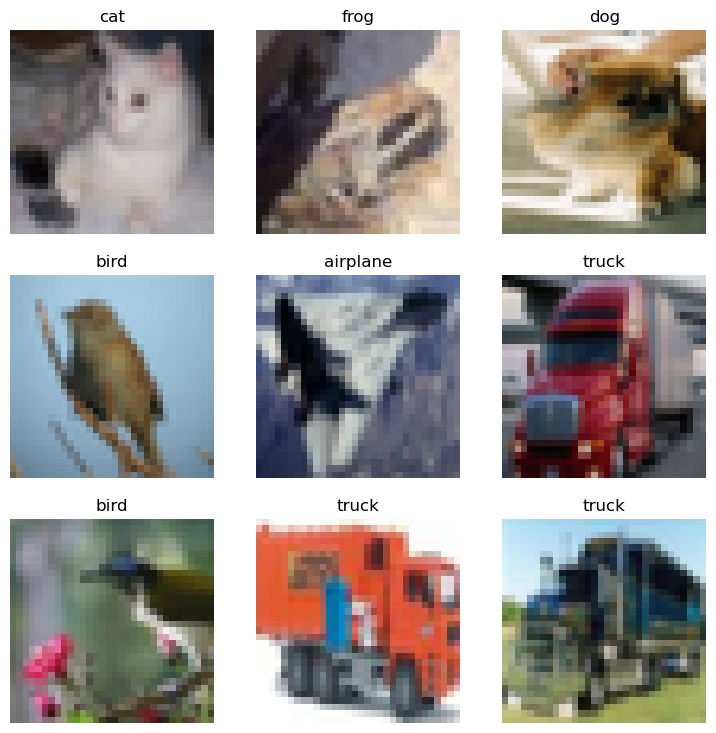

In [6]:
xb, yb = dls.one_batch()
dls.show_batch()

In [7]:
xb.max(), xb.min(), xb.mean(), xb.std()

(TensorImage(1., device='cuda:0'),
 TensorImage(-1., device='cuda:0'),
 TensorImage(-0.0532, device='cuda:0'),
 TensorImage(0.4992, device='cuda:0'))

## Conditional DDPM Training as a Callback

Same as DDPM callback but:
- We invert the x,y structure of the original callback
- Generates noise on the callback for the whole batch
- The sampling "before_batch_sampling" is done with labels that are fixed to [0,1,2,3,4...9,0,1,2,3....]

In [8]:
class ConditionalDDPMCallback(Callback):
    def __init__(self, n_steps, beta_min, beta_max, cfg_scale=0):
        store_attr()
        self.tensor_type=TensorImage

    def before_fit(self):
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.dls.device) # variance schedule, linearly increased with timestep
        self.alpha = 1. - self.beta 
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)
    
    def sample_timesteps(self, x, dtype=torch.long):
        return torch.randint(self.n_steps, (x.shape[0],), device=x.device, dtype=dtype)
    
    def generate_noise(self, x):
        return self.tensor_type(torch.randn_like(x))
    
    def noise_image(self, x, eps, t):
        alpha_bar_t = self.alpha_bar[t][:, None, None, None]
        return torch.sqrt(alpha_bar_t)*x + torch.sqrt(1-alpha_bar_t)*eps # noisify the image
    
    def before_batch_training(self):
        x0 = self.xb[0] # original images and labels
        y0 =  self.yb[0] if np.random.random() > 0.1 else None
        
        # y0 = None
        
        eps = self.generate_noise(x0) # noise same shape as x0
        t =  self.sample_timesteps(x0) # select random timesteps
        xt =  self.noise_image(x0, eps, t)  # add noise to the image
        # print(x0.shape, y0.shape, t.shape, xt.shape, eps.shape)
        
        self.learn.xb = (xt, t, y0) # input to our model is noisy image, timestep and label
        self.learn.yb = (eps,) # ground truth is the noise 

    def sampling_algo(self, xt, t, label=None):
        t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
        z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
        alpha_t = self.alpha[t] # get noise level at current timestep
        alpha_bar_t = self.alpha_bar[t]
        sigma_t = self.sigma[t]
        alpha_bar_t_1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1, device=xt.device)
        beta_bar_t = 1 - alpha_bar_t
        beta_bar_t_1 = 1 - alpha_bar_t_1
        predicted_noise = self.model(xt, t_batch, label=label)
        if self.cfg_scale>0:
            uncond_predicted_noise = self.model(xt, t_batch, label=None)
            predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, self.cfg_scale)
        x0hat = (xt - torch.sqrt(beta_bar_t) * predicted_noise)/torch.sqrt(alpha_bar_t)
        x0hat = torch.clamp(x0hat, -1, 1)
        xt = x0hat * torch.sqrt(alpha_bar_t_1)*(1-alpha_t)/beta_bar_t + xt * torch.sqrt(alpha_t)*beta_bar_t_1/beta_bar_t + sigma_t*z 

        return xt
    
    # def sampling_algo_old(self, xt, t, label=None):
    #     t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
    #     z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
    #     alpha_t = self.alpha[t] # get noise level at current timestep
    #     alpha_bar_t = self.alpha_bar[t]
    #     sigma_t = self.sigma[t]
    #     xt = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * self.model(xt, t_batch, label=label)) + sigma_t*z 
    #          1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     # predict x_(t-1) in accordance to Algorithm 2 in paper
    #     return xt
    
    def sample(self):
        xt = self.generate_noise(self.xb[0]) # a full batch at once!
        label = torch.arange(10, dtype=torch.long, device=xt.device).repeat(xt.shape[0]//10 + 1).flatten()[0:xt.shape[0]]
        for t in progress_bar(reversed(range(self.n_steps)), total=self.n_steps, leave=False):
            xt = self.sampling_algo(xt, t, label) 
        return xt
    
    def before_batch_sampling(self):
        xt = self.sample()
        self.learn.pred = (xt,)
        raise CancelBatchException
    
    def after_validate(self):
        if (self.epoch+1) % 4 == 0:
            with torch.no_grad():
                xt = self.sample()
                wandb.log({"preds": [wandb.Image(torch.tensor(im)) for im in xt[0:36]]})
    
    def before_batch(self):
        if not hasattr(self, 'gather_preds'): self.before_batch_training()
        else: self.before_batch_sampling()

In [9]:
class EMA(Callback):
    "Exponential Moving average CB"
    def __init__(self, beta=0.995, pct_start=0.3):
        store_attr()
        
    
    def before_fit(self):
        self.ema_model = deepcopy(self.model).eval().requires_grad_(False)
        self.step_start_ema = int(self.pct_start*self.n_epoch)  #start EMA at 30% of epochs
        
    def update_model_average(self):
        for current_params, ma_params in zip(self.model.parameters(), self.ema_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self):
        if self.epoch < self.step_start_ema:
            self.reset_parameters()
            self.step += 1
            return
        self.update_model_average()
        self.step += 1

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())
    
    def after_batch(self):
        if hasattr(self, 'pred'): return
        self.step_ema()
    
    def after_training(self):
        self.model = self.ema_model

We have to add the conditioning to the Unet, to do so, we just subclass it and inject the encoded label on the `forward` pass.

In [10]:
@delegates(Unet)
class ConditionalUnet(Unet):
    def __init__(self, dim, num_classes=None, **kwargs):
        super().__init__(dim=dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, dim * 4)
    
    def forward(self, x, time, label=None):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        if label is not None:
            t += self.label_emb(label)
            
        return super().forward_blocks(x, t)

Let's now initialize our model:

In [11]:
model = ConditionalUnet(dim=32, channels=3, num_classes=10).cuda()

Now we can create a fastai Learner with our DataLoaders, Callback (with the appropriate number of timesteps and noise schedule) and the simple MSE loss that we use to train DDPM.

In [12]:
import wandb
from fastai.callback.wandb import WandbCallback

In [13]:
ddpm_learner = Learner(dls, model, 
                       cbs=[ConditionalDDPMCallback(n_steps=1000, beta_min=0.0001, beta_max=0.02, cfg_scale=3),
                            EMA()], 
                       loss_func=nn.L1Loss())

Let's use fastai's amazing LR finder to select a good LR for training:

In [14]:
# ddpm_learner.lr_find()

And now let's train with one-cycle LR schedule:

In [15]:
wandb.init(project="ddpm_fastai", group="cifar10", tags=["fp", "ema"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


In [16]:
ddpm_learner.fit_one_cycle(epochs, 3e-4, cbs =[SaveModelCallback(monitor="train_loss", fname="cifar10"), 
                                               WandbCallback(log_preds=False, log_model=True)])

epoch,train_loss,valid_loss,time
0,0.750259,0.709923,00:42
1,0.632055,0.573980,00:40
2,0.490789,0.438364,00:40
3,0.356443,0.307267,03:25
4,0.270513,0.249062,00:40
5,0.221594,0.210910,00:40
6,0.190886,0.186583,00:40
7,0.168048,0.167804,03:25
8,0.152539,0.157809,00:40
9,0.144119,0.152306,00:40


Better model found at epoch 0 with train_loss value: 0.7502593398094177.
Better model found at epoch 1 with train_loss value: 0.6320550441741943.
Better model found at epoch 2 with train_loss value: 0.4907890260219574.


Better model found at epoch 3 with train_loss value: 0.3564431965351105.
Better model found at epoch 4 with train_loss value: 0.27051302790641785.
Better model found at epoch 5 with train_loss value: 0.22159354388713837.
Better model found at epoch 6 with train_loss value: 0.19088611006736755.


Better model found at epoch 7 with train_loss value: 0.16804789006710052.
Better model found at epoch 8 with train_loss value: 0.1525385081768036.
Better model found at epoch 9 with train_loss value: 0.14411911368370056.
Better model found at epoch 10 with train_loss value: 0.13733148574829102.


Better model found at epoch 11 with train_loss value: 0.13356511294841766.
Better model found at epoch 12 with train_loss value: 0.13178279995918274.
Better model found at epoch 13 with train_loss value: 0.1284581422805786.
Better model found at epoch 14 with train_loss value: 0.12506239116191864.


Better model found at epoch 15 with train_loss value: 0.12299712002277374.
Better model found at epoch 16 with train_loss value: 0.12122058123350143.
Better model found at epoch 17 with train_loss value: 0.11891119927167892.
Better model found at epoch 18 with train_loss value: 0.1185627207159996.


Better model found at epoch 19 with train_loss value: 0.11720366775989532.
Better model found at epoch 20 with train_loss value: 0.11533458530902863.
Better model found at epoch 21 with train_loss value: 0.11222967505455017.
Better model found at epoch 22 with train_loss value: 0.11185462772846222.


Better model found at epoch 23 with train_loss value: 0.11009092628955841.
Better model found at epoch 24 with train_loss value: 0.10919912904500961.
Better model found at epoch 26 with train_loss value: 0.10804483294487.


Better model found at epoch 27 with train_loss value: 0.10594470798969269.
Better model found at epoch 28 with train_loss value: 0.10550212115049362.


Better model found at epoch 31 with train_loss value: 0.10430967062711716.
Better model found at epoch 33 with train_loss value: 0.1027207300066948.


Better model found at epoch 35 with train_loss value: 0.10218702256679535.
Better model found at epoch 37 with train_loss value: 0.10062697529792786.


Better model found at epoch 39 with train_loss value: 0.10035884380340576.
Better model found at epoch 41 with train_loss value: 0.09969516843557358.


Better model found at epoch 43 with train_loss value: 0.09966123104095459.
Better model found at epoch 45 with train_loss value: 0.09875939041376114.
Better model found at epoch 46 with train_loss value: 0.09853431582450867.


Better model found at epoch 49 with train_loss value: 0.09744056314229965.


Better model found at epoch 55 with train_loss value: 0.09715472906827927.
Better model found at epoch 57 with train_loss value: 0.09665428847074509.


Better model found at epoch 62 with train_loss value: 0.09634526073932648.


Better model found at epoch 66 with train_loss value: 0.0962885320186615.


Better model found at epoch 67 with train_loss value: 0.09576054662466049.


Better model found at epoch 75 with train_loss value: 0.09555771201848984.
Better model found at epoch 76 with train_loss value: 0.09522632509469986.


Better model found at epoch 81 with train_loss value: 0.09490688145160675.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 96 with train_loss value: 0.09454851597547531.


Better model found at epoch 99 with train_loss value: 0.09405282139778137.


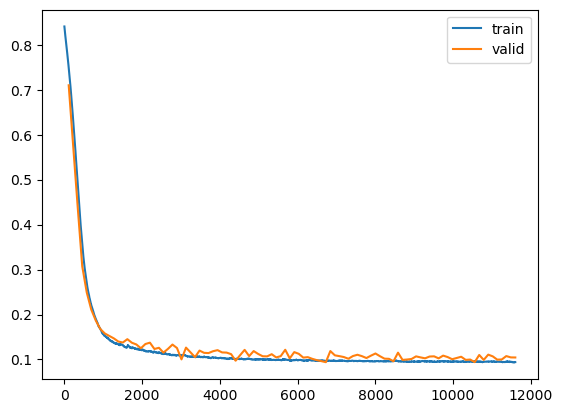

In [17]:
ddpm_learner.recorder.plot_loss()

## Sample generation

Since we implemented sampling in the Callback, we simply can call fastai's built-in `get_preds` function to get our predictions.

In [18]:
preds = ddpm_learner.get_preds()

we are passing a labels vector that looks like `[0,1,2,3,4,5,6,7,8,9,0,1,2,3,4.....]`

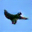

In [19]:
wandb.Image(torch.tensor(0.5*preds[0][0]+0.5)).image

In [23]:
p = preds[0]

In [24]:
p.shape

torch.Size([512, 3, 32, 32])

In [25]:
p.mean(dim=(0,2,3))

TensorImage([-0.0303, -0.0196, -0.0900])

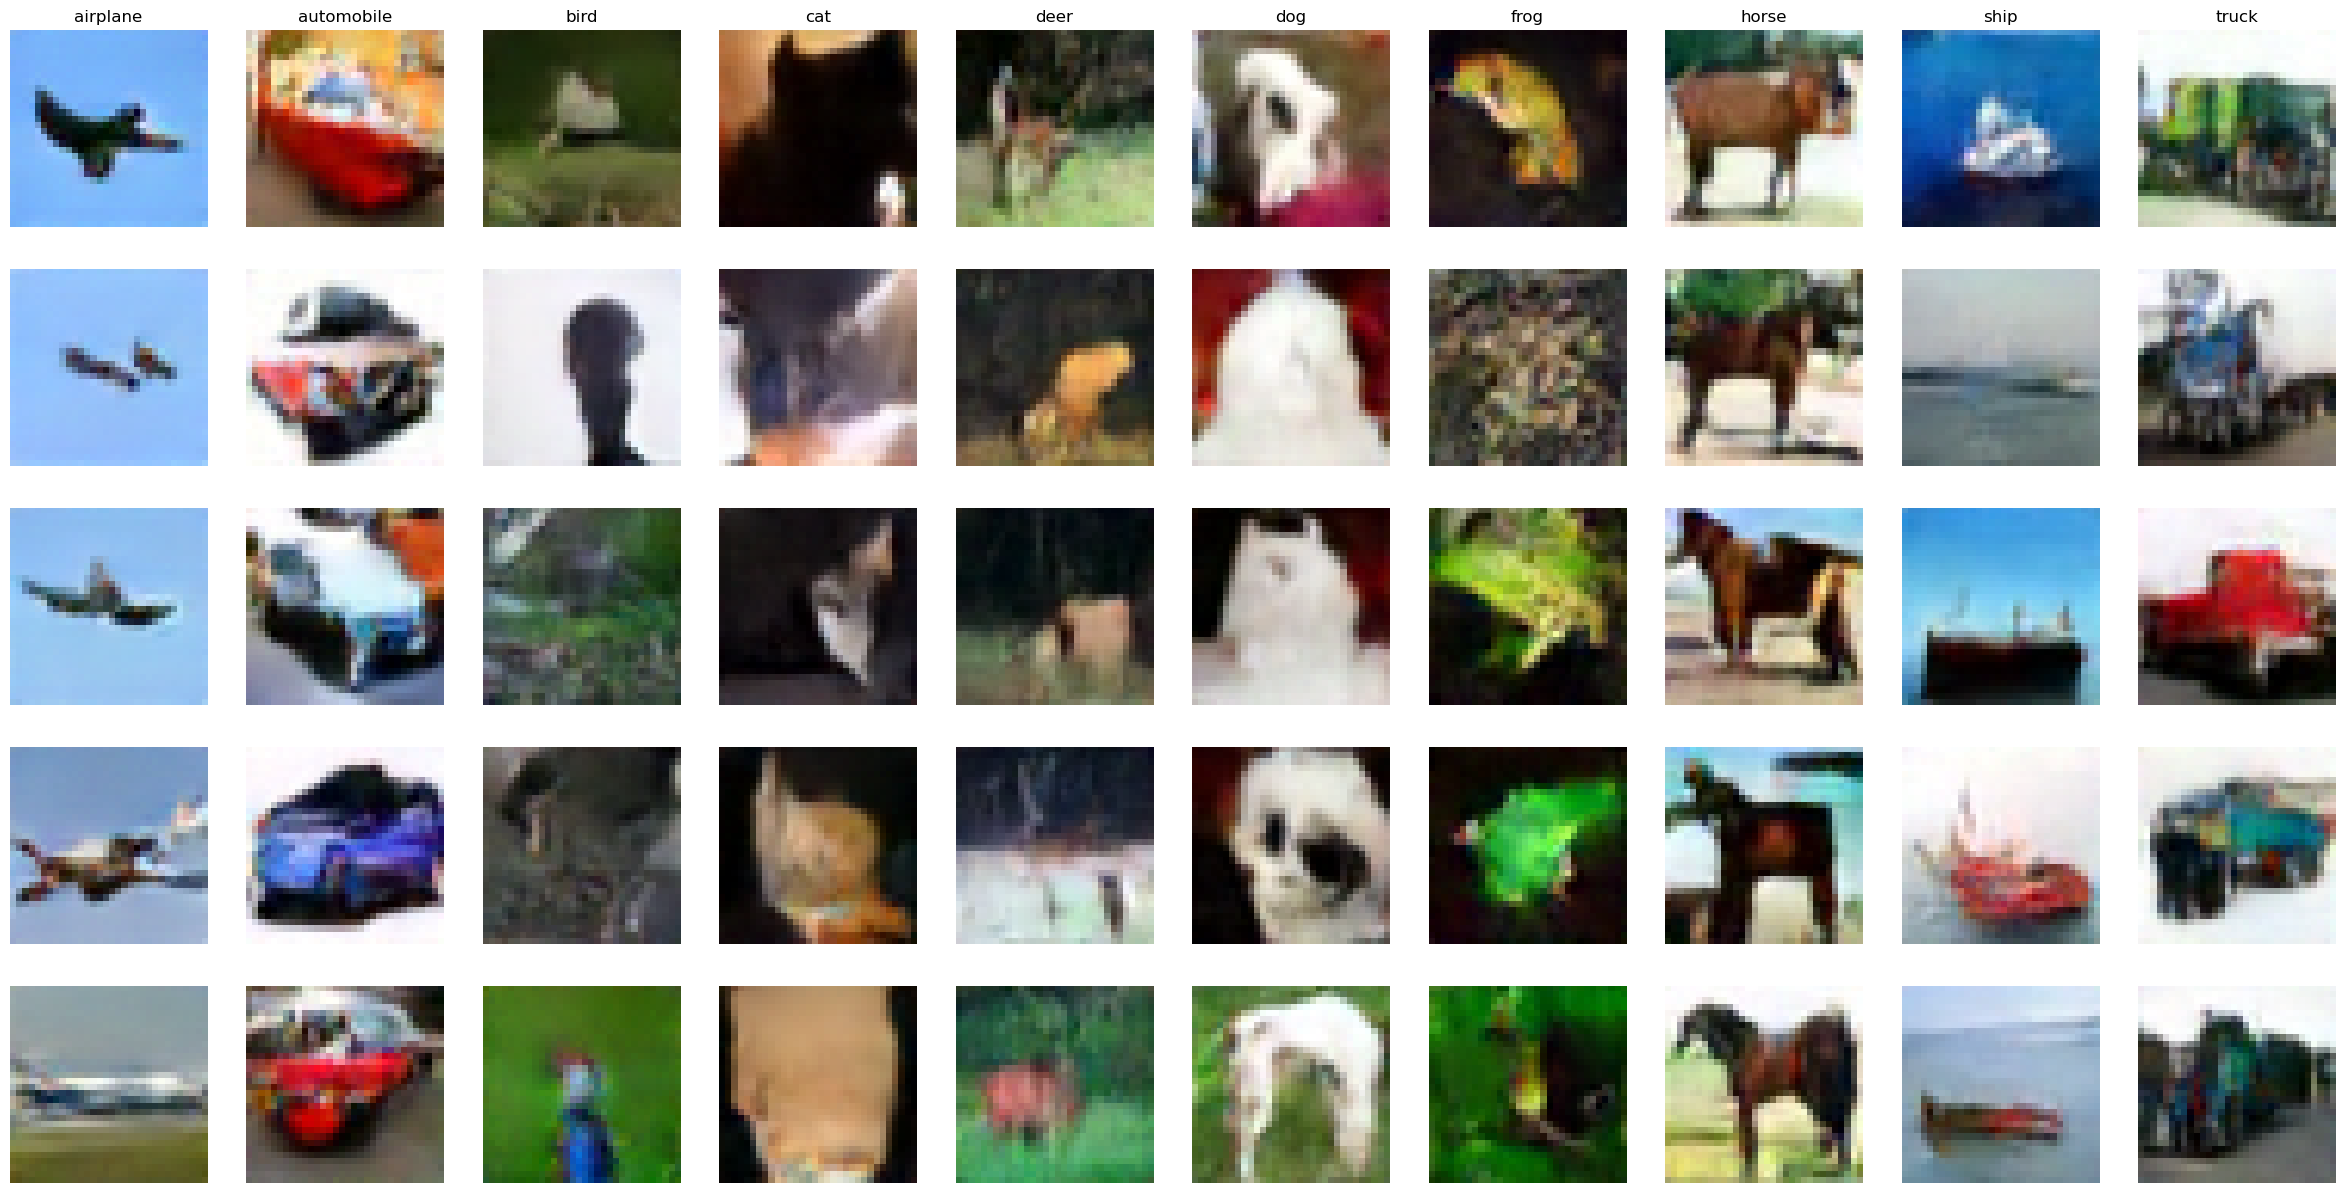

In [27]:
nrows=5
ncols = int(math.ceil(25/10))
axs = subplots(nrows, 10)[1].flat
for i, (pred, ax) in enumerate(zip(preds[0], axs)): 
    ((pred+1)/2).show(ax=ax, title=dls.vocab[i] if i<10 else None)

In [28]:
def log_table(rows=10):
    table = wandb.Table(columns=list(dls.vocab))
    for i, row in enumerate(preds[0].split(len(dls.vocab))):
        if i<rows:
            table.add_data(*[wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in row])
    wandb.log({"pred_table":table})

In [29]:
log_table()
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,████▁███████████████████████████████████
valid_loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100.0


Another useful thing to check is the prediction of the completely denoised image at some timestep. Our sampling takes our prediction of noise in the image but takes only a fraction of it to remove from the noisy image during the iterative process. But we can also try to see the full denoising prediction by fully subtracting out the prediction. Of course, at higher noise levels this will be inaccurate, but at lower noise levels it should be quite accurate.

In [30]:
eps = TensorImage(torch.randn(xb.shape, device=xb.device))
x0 = xb # original images
batch_size = x0.shape[0]
with torch.no_grad():
    t = torch.randint(0, ddpm_learner.conditional_ddpm.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
    alpha_bar_t = ddpm_learner.conditional_ddpm.alpha_bar[t].reshape(-1, 1, 1, 1)
    xt =  torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*eps # noisy images
    x0hat = (xt - torch.sqrt(1-alpha_bar_t)*ddpm_learner.model(xt,t))/torch.sqrt(alpha_bar_t) # predicted denoised images

Timestep 73 is closer to 0 so less noisy but noise is still visible.

In [31]:
np.where((t==73).cpu())[0]

array([], dtype=int64)

Now we can see the original clean image (x0), the noisy image (xt), and the model's attempt to remove the noise (x0hat)

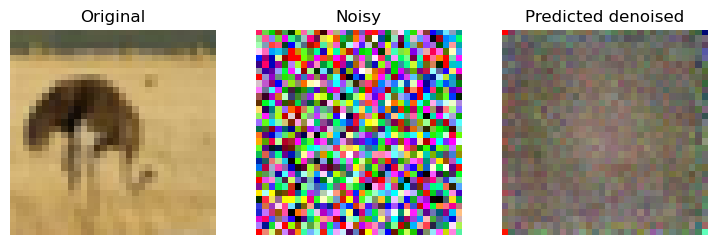

In [32]:
idx = 383
ctxs = get_grid(3,1,3)
ax1 = dls.after_batch.decode((x0,))[0][idx].show(ctx=ctxs[0], title='Original')
ax2 =  dls.after_batch.decode((xt,))[0][idx].show(ctx=ctxs[1], title='Noisy')
ax3 =  dls.after_batch.decode((x0hat,))[0][idx].show(ctx=ctxs[2], title='Predicted denoised')